# Import Package and Data

In [1]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [2]:
# reset schema https://forums.databricks.com/questions/14819/how-to-change-schema-of-a-pyspark-sql.html
data_schema = [StructField('user_id', StringType(), True), StructField('signup_time', StringType(), True), \
               StructField('purchase_time',StringType(), True),StructField('purchase_value',FloatType(),True),\
              StructField('device_id', StringType(), True),StructField('source', StringType(), True),\
              StructField('browser', StringType(), True), StructField('sex', StringType(), True),\
              StructField('age', IntegerType(), True),StructField('ip_address', DoubleType(), True),\
              StructField('class', IntegerType(), True)]
final_struc = StructType(fields=data_schema)
fraud = sqlContext.read.csv("data\\Fraud_Data.csv",header = True, schema=final_struc) # \t is tap; need to use \\

In [3]:
data_schema = [StructField('lower_bound_ip_address', DoubleType(), True), \
               StructField('upper_bound_ip_address', DoubleType(), True), \
               StructField('country',StringType(), True)]
final_struc = StructType(fields=data_schema)
ip = sqlContext.read.csv("data\\IpAddress_to_Country.csv",header = True, schema=final_struc) 

# 1. Data Exploration

## 1.1 Explore fraud - SparkSQL

In [4]:
# Number of Row 
fraud.count()

151112

In [5]:
fraud.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- signup_time: string (nullable = true)
 |-- purchase_time: string (nullable = true)
 |-- purchase_value: float (nullable = true)
 |-- device_id: string (nullable = true)
 |-- source: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ip_address: double (nullable = true)
 |-- class: integer (nullable = true)



In [6]:
fraud.columns 

['user_id',
 'signup_time',
 'purchase_time',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'ip_address',
 'class']

In [7]:
fraud.show(20)

+-------+-------------------+-------------------+--------------+-------------+------+-------+---+---+------------------+-----+
|user_id|        signup_time|      purchase_time|purchase_value|    device_id|source|browser|sex|age|        ip_address|class|
+-------+-------------------+-------------------+--------------+-------------+------+-------+---+---+------------------+-----+
|  22058|2015-02-24 22:55:49|2015-04-18 02:47:11|          34.0|QVPSPJUOCKZAR|   SEO| Chrome|  M| 39| 7.3275836879972E8|    0|
| 333320|2015-06-07 20:39:50|2015-06-08 01:38:54|          16.0|EOGFQPIZPYXFZ|   Ads| Chrome|  F| 53|3.50311387865908E8|    0|
|   1359|2015-01-01 18:52:44|2015-01-01 18:52:45|          15.0|YSSKYOSJHPPLJ|   SEO|  Opera|  M| 53|2.62147382011095E9|    1|
| 150084|2015-04-28 21:13:25|2015-05-04 13:54:50|          44.0|ATGTXKYKUDUQN|   SEO| Safari|  M| 41|3.84054244391396E9|    0|
| 221365|2015-07-21 07:09:52|2015-09-09 18:40:53|          39.0|NAUITBZFJKHWW|   Ads| Safari|  M| 45|4.15583117

In [8]:
# we need to change the datetype of signup_time and purchase time 
fraud2 = fraud.withColumn("signup_time", fraud["signup_time"].cast(TimestampType()))\
        .withColumn("purchase_time",fraud['purchase_time'].cast(TimestampType()))
fraud2.show()

+-------+-------------------+-------------------+--------------+-------------+------+-------+---+---+------------------+-----+
|user_id|        signup_time|      purchase_time|purchase_value|    device_id|source|browser|sex|age|        ip_address|class|
+-------+-------------------+-------------------+--------------+-------------+------+-------+---+---+------------------+-----+
|  22058|2015-02-24 22:55:49|2015-04-18 02:47:11|          34.0|QVPSPJUOCKZAR|   SEO| Chrome|  M| 39| 7.3275836879972E8|    0|
| 333320|2015-06-07 20:39:50|2015-06-08 01:38:54|          16.0|EOGFQPIZPYXFZ|   Ads| Chrome|  F| 53|3.50311387865908E8|    0|
|   1359|2015-01-01 18:52:44|2015-01-01 18:52:45|          15.0|YSSKYOSJHPPLJ|   SEO|  Opera|  M| 53|2.62147382011095E9|    1|
| 150084|2015-04-28 21:13:25|2015-05-04 13:54:50|          44.0|ATGTXKYKUDUQN|   SEO| Safari|  M| 41|3.84054244391396E9|    0|
| 221365|2015-07-21 07:09:52|2015-09-09 18:40:53|          39.0|NAUITBZFJKHWW|   Ads| Safari|  M| 45|4.15583117

In [9]:
fraud2.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- signup_time: timestamp (nullable = true)
 |-- purchase_time: timestamp (nullable = true)
 |-- purchase_value: float (nullable = true)
 |-- device_id: string (nullable = true)
 |-- source: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ip_address: double (nullable = true)
 |-- class: integer (nullable = true)



In [10]:
## Categorical variables 
def group(x):
    fraud2.groupBy(x).count().show()
group('source')

+------+-----+
|source|count|
+------+-----+
|   SEO|60615|
|Direct|30616|
|   Ads|59881|
+------+-----+



Most transaction were made through SEO or Ads. 

In [11]:
group('browser')

+-------+-----+
|browser|count|
+-------+-----+
|FireFox|24610|
| Safari|24667|
|     IE|36727|
| Chrome|61432|
|  Opera| 3676|
+-------+-----+



Most transaction were made through Chrome. 

In [12]:
group('sex')

+---+-----+
|sex|count|
+---+-----+
|  F|62819|
|  M|88293|
+---+-----+



Most purchasers are men

In [13]:
group('class')

+-----+------+
|class| count|
+-----+------+
|    1| 14151|
|    0|136961|
+-----+------+



only 9.3% of the users are fradulent

## 1.2. Explore IpAddress - SparkSQL

In [14]:
ip.printSchema()

root
 |-- lower_bound_ip_address: double (nullable = true)
 |-- upper_bound_ip_address: double (nullable = true)
 |-- country: string (nullable = true)



In [15]:
ip.show()

+----------------------+----------------------+---------+
|lower_bound_ip_address|upper_bound_ip_address|  country|
+----------------------+----------------------+---------+
|           1.6777216E7|           1.6777471E7|Australia|
|           1.6777472E7|           1.6777727E7|    China|
|           1.6777728E7|           1.6778239E7|    China|
|            1.677824E7|           1.6779263E7|Australia|
|           1.6779264E7|           1.6781311E7|    China|
|           1.6781312E7|           1.6785407E7|    Japan|
|           1.6785408E7|           1.6793599E7|    China|
|             1.67936E7|           1.6809983E7|    Japan|
|           1.6809984E7|           1.6842751E7| Thailand|
|           1.6842752E7|           1.6843007E7|    China|
|           1.6843008E7|           1.6843263E7|Australia|
|           1.6843264E7|           1.6843775E7|    China|
|           1.6843776E7|           1.6844799E7|    China|
|             1.68448E7|           1.6846847E7|    China|
|           1.

## 1.3. Merge two table  - Pandas and Numpy package 

In [16]:
# We need to match user ip address and their countries 
import pandas as pd
import numpy as np 
fraud_pd = fraud2.toPandas()
ip_pd = ip.toPandas()

In [17]:
fraud_pd.dtypes

user_id                   object
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value           float32
device_id                 object
source                    object
browser                   object
sex                       object
age                        int32
ip_address               float64
class                      int32
dtype: object

In [18]:
fraud_pd

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42.0,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11.0,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27.0,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30.0,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62.0,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [19]:
ip_pd.columns

Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')

In [20]:
def match_ip(a):
    match = (a >= ip_pd['lower_bound_ip_address']) & (a <= ip_pd['upper_bound_ip_address'])
    if match.any():
        return ip_pd['country'][match].to_string(index=False)
    else: 
        return np.nan 
fraud_pd['country'] = fraud_pd['ip_address'].apply(lambda x:match_ip(x))


In [21]:
fraud_pd.head(20)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42.0,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11.0,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,NaN
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27.0,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30.0,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62.0,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


In [22]:
# user population by country
"""
# This codes didn't include NA
count_by_country = fraud_pd[['user_id','country']].groupby('country').count(dropna= False).sort_values(by = 'user_id',ascending = False)
count_by_country
"""
fraud_pd['country'].value_counts(dropna = False)

 United States                      58049
NaN                                 21966
 China                              12038
 Japan                               7306
 United Kingdom                      4490
 Korea Republic of                   4162
 Germany                             3646
 France                              3161
 Canada                              2975
 Brazil                              2961
 Italy                               1944
 Australia                           1844
 Netherlands                         1680
 Russian Federation                  1616
 India                               1310
 Taiwan; Republic of China (ROC)     1237
 Mexico                              1121
 Sweden                              1090
 Spain                               1027
 South Africa                         838
 Switzerland                          785
 Poland                               729
 Argentina                            661
 Indonesia                        

182 groups of records, including 181 countries. To further modeling, I suggest to group some of the class together. 

In [23]:
# check for null value 
# sources: https://stackoverflow.com/questions/34537048/how-to-count-nan-values-in-a-pandas-dataframe
fraud_pd.isnull().sum()

user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           21966
dtype: int64

When mathc the ip_adress in the fraud table, only countries exists Null value, we decide to convert this NULL value to "unknown". 

In [24]:
# ref https://stackoverflow.com/questions/17097236/replace-invalid-values-with-none-in-pandas-dataframe
fraud_pd['country'] = fraud_pd['country'].replace(np.nan,'unknown')

In [25]:
fraud_pd['country'].value_counts(dropna = False)

 United States                      58049
unknown                             21966
 China                              12038
 Japan                               7306
 United Kingdom                      4490
 Korea Republic of                   4162
 Germany                             3646
 France                              3161
 Canada                              2975
 Brazil                              2961
 Italy                               1944
 Australia                           1844
 Netherlands                         1680
 Russian Federation                  1616
 India                               1310
 Taiwan; Republic of China (ROC)     1237
 Mexico                              1121
 Sweden                              1090
 Spain                               1027
 South Africa                         838
 Switzerland                          785
 Poland                               729
 Argentina                            661
 Indonesia                        

In [26]:
"""
# apply() is too slow for big data, it's better to use merge, merge is 1000x faster
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_name = country_name.strip()
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except: 
        return np.nan

# Example
fraud_pd['continent'] = fraud_pd['country'].apply(lambda x: country_to_continent(x))
fraud_pd
"""

"\n# apply() is too slow for big data, it's better to use merge, merge is 1000x faster\nimport pycountry_convert as pc\n\ndef country_to_continent(country_name):\n    try:\n        country_name = country_name.strip()\n        country_alpha2 = pc.country_name_to_country_alpha2(country_name)\n        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)\n        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)\n        return country_continent_name\n    except: \n        return np.nan\n\n# Example\nfraud_pd['continent'] = fraud_pd['country'].apply(lambda x: country_to_continent(x))\nfraud_pd\n"

In [27]:
country_to_continent = pd.read_csv("country.csv",sep = ",")

In [28]:
# add continent to the fraud_pd table 
fraud_pd['country'] = fraud_pd['country'].str.strip().str.lower()
country_to_continent['country'] = country_to_continent['country'].str.strip().str.lower()

df = pd.merge(fraud_pd,country_to_continent,on = 'country', how ="left")


In [29]:
df['continent'] = df['continent'].replace(np.nan,'unknown')

In [52]:
df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,continent,duration
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,japan,Asia,52.160671
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,united states,North America,0.207685
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,united states,North America,0.000012
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,unknown,unknown,5.695428
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,united states,North America,50.479873
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42.0,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,canada,North America,49.084850
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11.0,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,unknown,unknown,25.206308
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27.0,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,united states,North America,49.406586
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30.0,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,china,Asia,41.599537
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62.0,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,united states,North America,57.219363


In [30]:
df.to_csv("merge_table.csv",index = False)

## 1.4 Basic EDA - Data Visualization

In [31]:
df.dtypes

user_id                   object
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value           float32
device_id                 object
source                    object
browser                   object
sex                       object
age                        int32
ip_address               float64
class                      int32
country                   object
continent                 object
dtype: object

In [32]:
import matplotlib
import matplotlib.pyplot as plt



Classfy different data type 
ref: https://stackoverflow.com/questions/19900202/how-to-determine-whether-a-column-variable-is-numeric-or-not-in-pandas-numpy/45568283#45568283

In [33]:
# add one variable 
#calculate the days between purchase_time and signup_time 

df['duration'] = df['purchase_time'] - df['signup_time']
df['duration']=df['duration']/np.timedelta64(1,'D')
 

In [34]:
from pandas.api.types import is_string_dtype
categorical_variable = []
for i in df.columns:
    if i != 'user_id' and i != "device_id":
        if df[i].dtypes == 'object' or is_string_dtype(df[i]):
            categorical_variable += [i]
categorical_variable

['source', 'browser', 'sex', 'country', 'continent']

In [35]:
from pandas.api.types import is_numeric_dtype
numerical_variable = []
for i in df.columns:
    if i != 'user_id' or i != "device_id":
        if  is_numeric_dtype(df[i]):
            numerical_variable += [i]
numerical_variable

['purchase_value', 'age', 'ip_address', 'class', 'duration']

### 1.4.1 Univariate Analysis 

#### 1.4.1.1 Non-Graphical Analysis 

Numeric Variables 

In [36]:
# Quick Statistics
df.describe()

,purchase_value,age,ip_address,class,duration
count,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000
mean,36.935371,33.140704,2.152145e+09,0.093646,57.083669
std,18.322712,8.617733,1.248497e+09,0.291336,36.183597
min,9.000000,18.000000,5.209350e+04,0.000000,0.000012
25%,22.000000,27.000000,1.085934e+09,0.000000,25.309647
50%,35.000000,33.000000,2.154770e+09,0.000000,57.017888
75%,49.000000,39.000000,3.243258e+09,0.000000,88.478293
max,154.000000,76.000000,4.294850e+09,1.000000,119.999676


+ Summary:
1. purchase value from $9 to $154, and average value is around $37
2. users' age is from 18 to 76, and average age is 33
3. from Class, we found 9.5% is fraudulent 
4. On average, users purchase products around 57 days after signing up their accounts. 

Categorical Variables

In [37]:
for i in categorical_variable:
    print(df[i].value_counts(dropna = False).sort_values(ascending = False))

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64
M    88293
F    62819
Name: sex, dtype: int64
united states                      58049
unknown                            21966
china                              12038
japan                               7306
united kingdom                      4490
korea republic of                   4162
germany                             3646
france                              3161
canada                              2975
brazil                              2961
italy                               1944
australia                           1844
netherlands                         1680
russian federation                  1616
india                               1310
taiwan; republic of china (roc)     1237
mexico                              1121
sweden                              1090
spain                       

#### 1.4.1.2 Graphical analysis 

Categorical Variables 

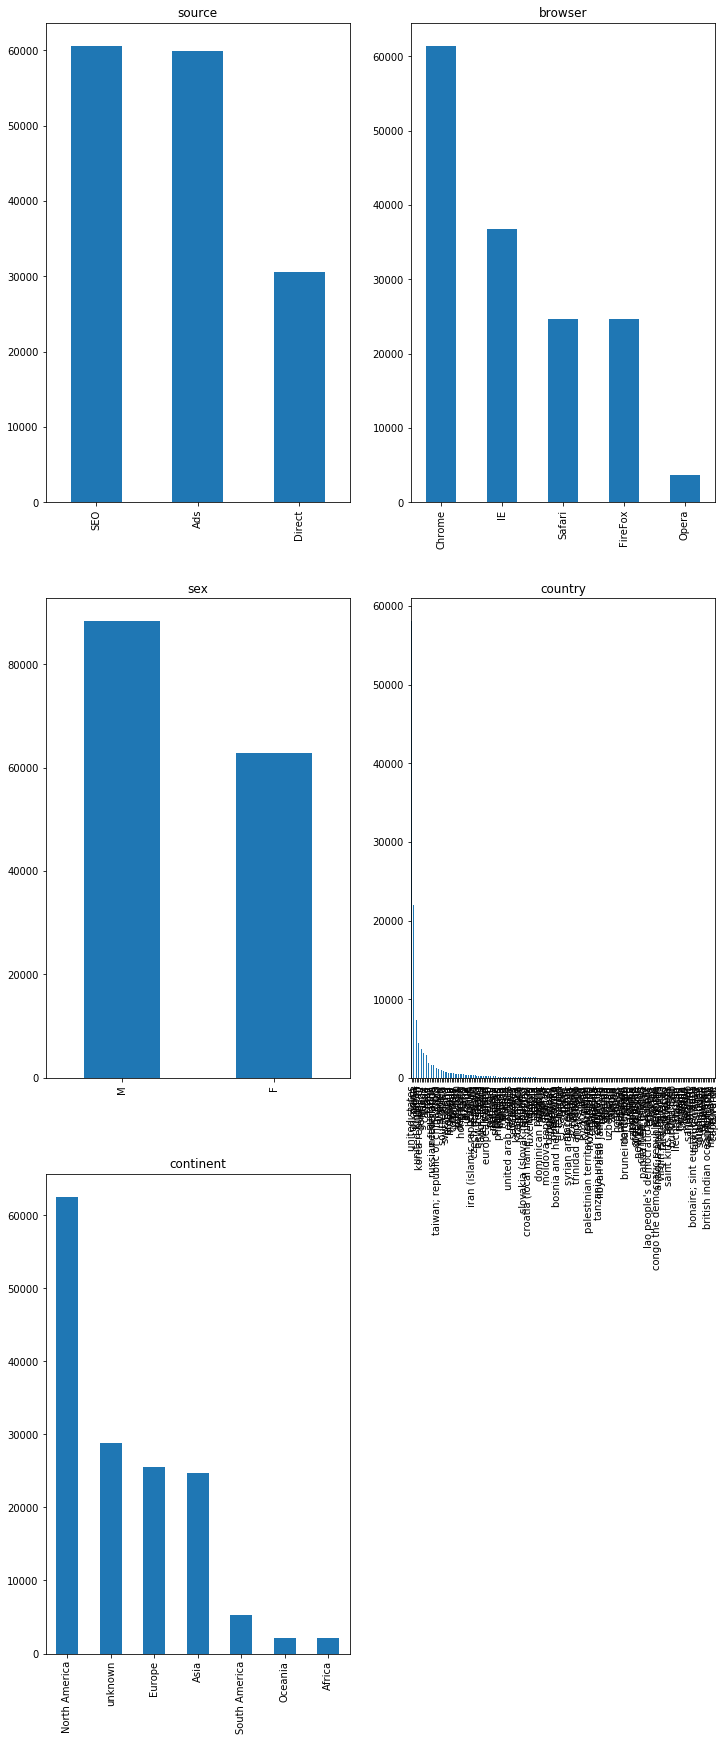

In [38]:
import seaborn as sns
import math 
for i in range(0,len(categorical_variable)):
    plt.subplot(math.ceil(len(categorical_variable)/2),2,i+1)
    var =df[categorical_variable[i]].value_counts(dropna=False)
    var.plot(title = categorical_variable[i], kind = 'bar',figsize=(12,30))


Summary: 

1. Most users came from North America, and there's a great amount of users who have an undetected country. 
2. Same result as SparkSQL 

Numerical variables 

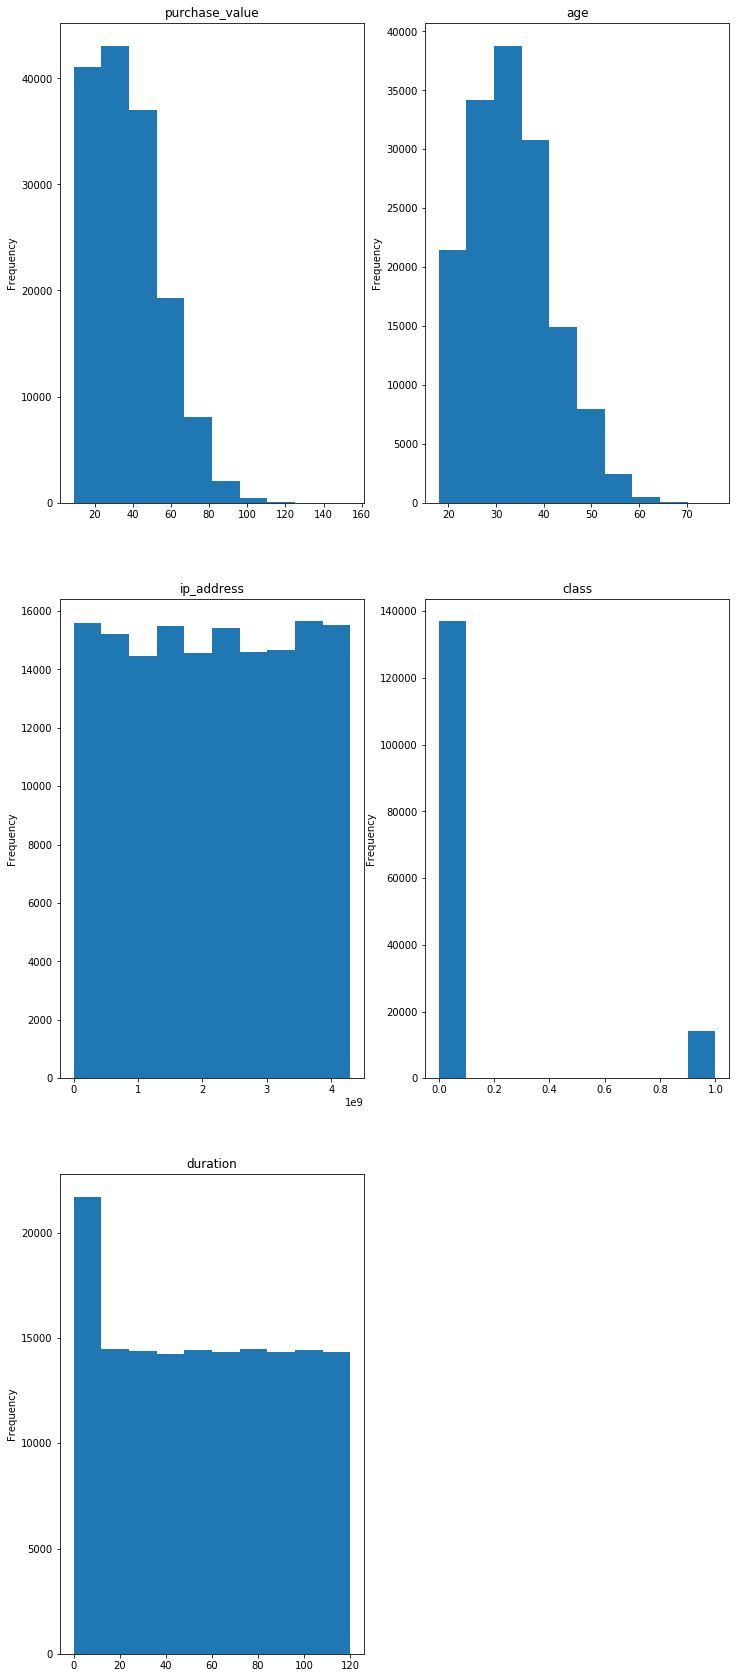

In [39]:
for i in range(0,len(numerical_variable)):
    plt.subplot(math.ceil(len(numerical_variable)/2),2,i+1)
    df[numerical_variable[i]].plot(title = numerical_variable[i], kind = 'hist',figsize=(12,30))

Ip address is not effective, so we decide to abandon it. 

### 1.4.2 Multi-variate analysis

#### 1.4.2.1 Non-graphical analysis

##### Categorical Variables 

In [40]:
# ref : https://pbpython.com/pandas-crosstab.html
for i in categorical_variable:
    print(pd.crosstab(df[i],df['class'],margins = True, margins_name = "Total", normalize = True))

class          0         1     Total
source                              
Ads     0.359786  0.036483  0.396269
Direct  0.181256  0.021348  0.202605
SEO     0.365312  0.035814  0.401126
Total   0.906354  0.093646  1.000000
class           0         1     Total
browser                              
Chrome   0.366371  0.040162  0.406533
FireFox  0.147361  0.015498  0.162859
IE       0.221955  0.021090  0.243045
Opera    0.022156  0.002171  0.024326
Safari   0.148512  0.014724  0.163237
Total    0.906354  0.093646  1.000000
class         0         1     Total
sex                                
F      0.377879  0.037833  0.415712
M      0.528476  0.055813  0.584288
Total  0.906354  0.093646  1.000000
class                                   0         1     Total
country                                                      
afghanistan                      0.000033  0.000007  0.000040
albania                          0.000086  0.000000  0.000086
algeria                          0.000721  0.0

### 1.4.2.2 Graphical analysis 

##### Categorical Variables 

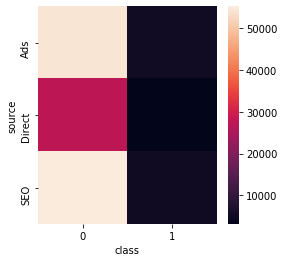

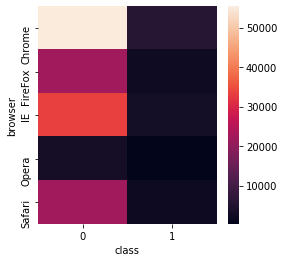

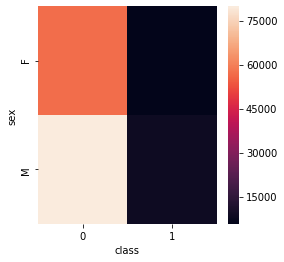

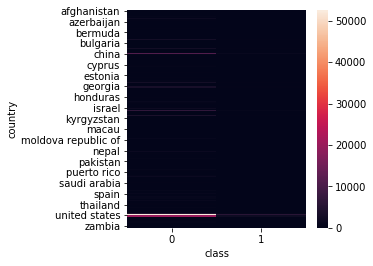

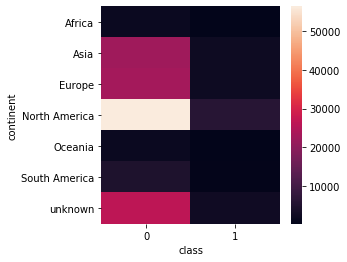

In [41]:
for i in range(0,len(categorical_variable)):
    plt.figure(figsize=(4,4))
    var = pd.crosstab(df[categorical_variable[i]],df['class'])
    sns.heatmap(var)

Rule: high population results in high proportion in each class

##### Continuous Variables - Correlation

In [42]:
df[numerical_variable].corr()

,purchase_value,age,ip_address,class,duration
purchase_value,1.000000,0.002370,-0.000328,0.001011,0.003441
age,0.002370,1.000000,0.001140,0.006624,-0.000575
ip_address,-0.000328,0.001140,1.000000,-0.005208,0.003387
class,0.001011,0.006624,-0.005208,1.000000,-0.257888
duration,0.003441,-0.000575,0.003387,-0.257888,1.000000


All pairs of numerical varibales don't have strong relationship between each other. 

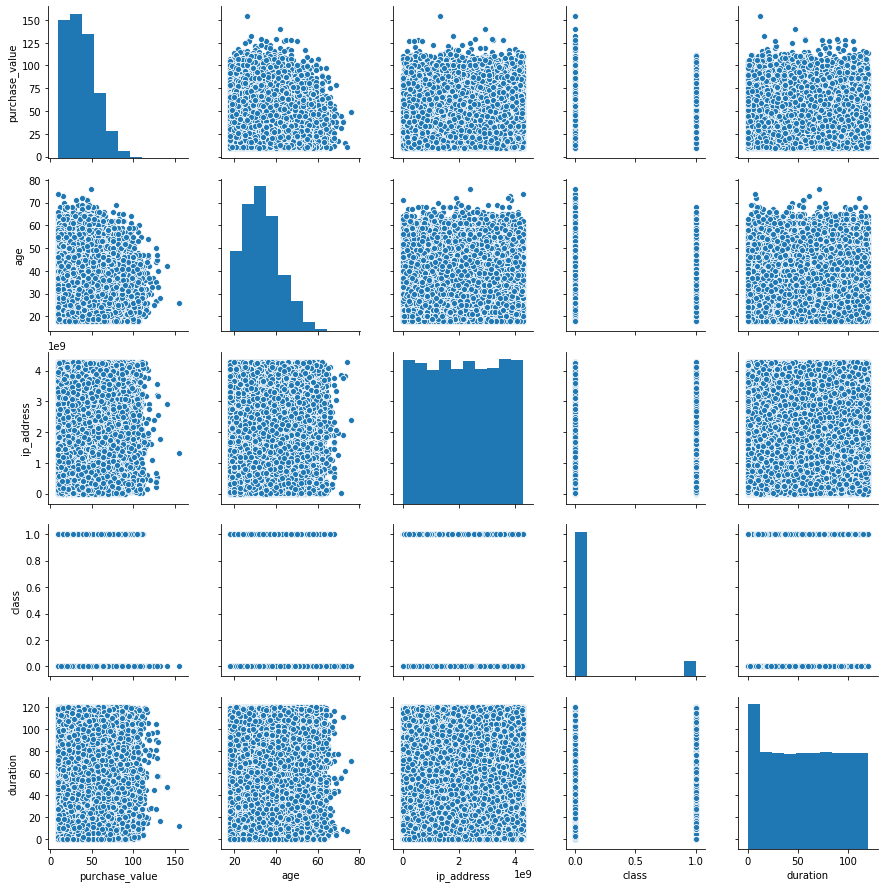

In [43]:
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166ref : https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df[numerical_variable])

## 1.5 Data Cleaning

1. abandon ip_address
2. abandon datetime  
3. abandon device_id, change to whether use duplicate device 

In [44]:
new_df = df

In [45]:
new_df.columns 

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'continent', 'duration'],
      dtype='object')

In [46]:
# Calculate the times of same device used 
f = pd.DataFrame(df.groupby(['device_id']).count()['user_id']).reset_index()
f.columns = ['device_id', 'device_count']

In [47]:
new_df = new_df.merge(f,on = 'device_id', how = 'left')

In [48]:

df['user_id'].value_counts().sort_values(ascending = False)

289328    1
29936     1
398279    1
373053    1
92853     1
254199    1
88280     1
39027     1
335728    1
350541    1
56952     1
126766    1
346754    1
69327     1
365883    1
315897    1
270117    1
159617    1
81548     1
277239    1
204704    1
18780     1
13896     1
146174    1
188238    1
125478    1
357406    1
333621    1
196727    1
68704     1
         ..
50481     1
376070    1
282182    1
96501     1
267968    1
59153     1
81244     1
116210    1
275012    1
254095    1
164014    1
76854     1
329945    1
266392    1
266989    1
252930    1
298922    1
258230    1
142128    1
360993    1
266132    1
349292    1
209925    1
346712    1
6982      1
16855     1
264140    1
350591    1
254569    1
252839    1
Name: user_id, Length: 151112, dtype: int64

Unique Id

In [49]:
del new_df['ip_address']
del new_df['signup_time']
del new_df['purchase_time']
del new_df['user_id']
del new_df['device_id']

In [50]:
new_df

,purchase_value,source,browser,sex,age,class,country,continent,duration,device_count
0,34.0,SEO,Chrome,M,39,0,japan,Asia,52.160671,1
1,16.0,Ads,Chrome,F,53,0,united states,North America,0.207685,1
2,15.0,SEO,Opera,M,53,1,united states,North America,0.000012,12
3,44.0,SEO,Safari,M,41,0,unknown,unknown,5.695428,1
4,39.0,Ads,Safari,M,45,0,united states,North America,50.479873,1
5,42.0,Ads,Chrome,M,18,0,canada,North America,49.084850,1
6,11.0,Ads,Chrome,F,19,0,unknown,unknown,25.206308,1
7,27.0,Ads,Opera,M,34,0,united states,North America,49.406586,1
8,30.0,SEO,IE,F,43,0,china,Asia,41.599537,1
9,62.0,Ads,IE,M,31,0,united states,North America,57.219363,1


In [51]:
new_df.to_csv('new_df.csv', index = False)